# Hybrid quantum-classical machine learning with PyTorch and Qiskit

Machine learning has established itself as a successful multidisciplinary field that aims to create artificially intelligent systems by enabling machines to learn from data. Throwing in quantum computing gives rise to interesting areas of research that seek to leverage the principles of quantum mechanics for machine learning (ML) computation or vice-versa. Whether you're aiming to enhance classical ML algorithms by outsourcing difficult calculations to a quantum computer or optimise quantum algorithms using classical ML architectures - both are examples of [hybrid quantum-classical machine learning](https://pennylane.ai/qml/concepts.html#hybrid-computation). 

In this chapter, we introduce the notion of hybrid computation through a very simple example involving [neural networks](https://www.youtube.com/watch?v=aircAruvnKk) using the state-of-the-art open source software package - [PyTorch](https://pytorch.org/). The purpose of this example is to demonstrate the ease of integrating ML with Qiskit and to encourage ML practitioners to explore what is possible with quantum computing. 

<h1><center>How does it work?</center></h1>
<img src="hybridnetwork.png" width = "800" />

The figure above illustrates the framework we will construct in this chapter. Ultimately, we will create a hybrid quantum-classical neural network that optimises both classical and quantum parameters in order to do classification. 

### What does that mean?
Typically, a neural network takes in input data in the form of classical vectors. These inputs are multiplied by [weights](https://en.wikipedia.org/wiki/Artificial_neural_network#Connections_and_weights) which connect the inputs to neurons in the hidden layers of a neural network. The number of neurons in any hidden layer can be specified and often depend on the problem at hand. By creating a quantum-classical neural network, one can simply use a [parameterised quantum circuit](https://pennylane.ai/qml/concepts/varcirc.html) in any of the hidden layers where the neurons can now be thought of as the parameter values for the quantum circuit. The output of the quantum circuit are measurements that can act as values for neurons in the next hidden layer. In other words, there can be interplay between classical and quantum objects where the parameters of a [variational quantum circuit](https://pennylane.ai/qml/concepts/varcirc.html) are "quantum neurons" optimised through training of the weights in our neural network. The full neural network will thus seek to optimise over both classical and quantum parameters. A simple example is depicted below:

<img src="neuralnetworkQC.png" width = "800" />

Here, $\sigma$ is an [activation function](https://en.wikipedia.org/wiki/Activation_function) and $h_i$ is the value of neuron $i$ at each hidden layer. $R(h_i)$ represents any rotation gate about an angle equal to $h_i$ and $y$ is the final prediction value generated from the hybrid network.  

### What about backpropagation?
If you're familiar with classical ML, you may immediately be wondering *how do we calculate gradients when quantum circuits are involved?* This would be necessary to perform cool optimisation techniques like [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). It gets a bit technical, but in short, we can view a quantum circuit as a black box and the gradient of this black box with respect to its parameters is calculated as follows: 

<img src="quantumgradient.png" width = "800" />

where $\theta$ represents the parameters of the quantum circuit and $s$ is a macroscopic shift. Thus, the gradient is simply the difference between the quantum circuit evaluated at $\theta+s$ and $\theta - s$. The technical proof can be found [here](https://pennylane.ai/qml/concepts/autograd_quantum.html#a-more-technical-explanation) and this means that automatic differentiation with quantum circuits is not a problem. 

<h1><center>Let's code!</center></h1>

### Imports
First, we import some handy packages that we will need, including Qiskit and PyTorch.

In [1]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

### Tensors to lists
Next we create an additional function that converts a tensor to a list in Python. This is needed to connect Qiskit and PyTorch objects. In particular, we will use this function to convert tensors produced by PyTorch to a list, such that they can be fed into quantum circuits in Qiskit.

In [2]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

### Create a "quantum class" with Qiskit
We can conveniently put our Qiskit quantum functions into a class. First, we specify how many trainable quantum parameters and how many shots we wish to use in our quantum circuit. In this example, we will keep it simple and use a 1-qubit circuit with one trainable quantum parameter $\theta$. We hard code the circuit for simplicity and use a $RY-$rotation by the angle $\theta$ to train the output of our circuit. The circuit looks like this:

<img src="1qubitcirc.png" width = "400" />

In order to measure the output in the $z-$basis, we create a Python function to obtain the $\sigma_z$ expectation. Lastly, we create a "bind" function to convert our parameter to a list and run the circuit on the Aer simulator. We will see later how this all ties into the hybrid neural network.

In [3]:
class QiskitCircuit():
    
    # Specify initial parameters and the quantum circuit
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.ry(self.theta,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

### Create a "quantum-classical class" with PyTorch
Now that our quantum circuit is defined, we can create the functions needed for backpropagation using PyTorch. [The forward and backward passes](http://www.ai.mit.edu/courses/6.034b/backprops.pdf) contain elements from our Qiskit class. The backward pass directly computes the analytical gradients using the finite difference formula we introduced above.

In [4]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value]) # store the result as a torch tensor
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors  
        
        # Obtain paramaters 
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s  # Shift up by s
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s # Shift down by s
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()

<h1><center>Putting this all together</center></h1>
We will create a simple hybrid neural network to classify images of two types of digits (0 or 1) from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). We first load MNIST and filter for pictures containing 0's and 1's. These will serve as inputs for our neural network to classify.

### Data loading and preprocessing

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

labels = mnist_trainset.targets # get the labels for the data
labels = labels.numpy()

idx1 = np.where(labels == 0) # filter on zeros
idx2 = np.where(labels == 1) # filter on ones

# Specify number of datapoints per class (i.e. there will be n pictures of 1 and n pictures of 0 in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
mnist_trainset.targets = labels[idx] 
mnist_trainset.data = mnist_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1, shuffle=True)

The data will consist of images belonging to two classes: 0 and 1. An example image from both classes looks like this:

<img src="MNISTplot.png" width = "100" />

So far, we have loaded the data and coded a class that creates our quantum circuit which contains 1 trainable parameter. This quantum parameter will be inserted into a classical neural network along with the other classical parameters to form the hybrid neural network. We also created backward and forward pass functions that allow us to do backpropagation and optimise our neural network. Lastly, we need to specify our neural network architecture such that we can begin to train our parameters using optimisation techniques provided by PyTorch. 


### Creating the hybrid neural network
We can use a neat PyTorch pipeline to create a neural network architecture. The network will need to be compatible in terms of its dimensionality when we insert the quantum node (i.e. our quantum circuit). Since our quantum node in this example contains 1 parameter, we must ensure the network condenses neurons down to size 1. We create a network consisting of 3 hidden layers with 320, 50 and 1 neurons respectively. The value of the last neuron is fed as the parameter $\theta$ into our quantum circuit. The circuit measurement then serves as the final prediction for 0 or 1 as provided by a $\sigma_z$ measurement. The measurement outcomes are -1 which implies a predicted label of 0 and 1 which implies a predicted label of 1. 

In [6]:
qc = TorchCircuit.apply 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.h1 = nn.Linear(320, 50)
        self.h2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.h1(x))
        x = F.dropout(x, training=self.training)
        x = self.h2(x)
        x = qc(x)
        x = (x+1)/2  # Normalise the inputs to 1 or 0
        x = torch.cat((x, 1-x), -1)
        return x

### Training the network
We now have all the ingredients to train our hybrid network! We can specify any [PyTorch optimiser](https://pytorch.org/docs/stable/optim.html), [learning rate](https://en.wikipedia.org/wiki/Learning_rate) and [cost/loss function](https://en.wikipedia.org/wiki/Loss_function) in order to train over multiple epochs. In this instance, we use the [Adam optimiser](https://arxiv.org/abs/1412.6980), a learning rate of 0.001 and the [negative log-likelihood loss function](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html).

-0.6282500000000002
-0.7656999999999999
-0.7852499999999991
-0.7806500000000003
-0.7706499999999997
-0.7907499999999998
-0.7934999999999997
-0.8000499999999994
-0.8040500000000005
-0.8073999999999997
-0.7906999999999997
-0.8235499999999996
-0.8144499999999997
-0.8119499999999998
-0.8192499999999998
-0.8231999999999998
-0.8070500000000002
-0.8279000000000003
-0.8181
-0.825
-0.8253499999999998
-0.8277500000000004
-0.8234999999999996
-0.8311999999999995
-0.8251000000000002
-0.83265
-0.8251
-0.8250499999999996
-0.8258999999999997
-0.8252000000000004


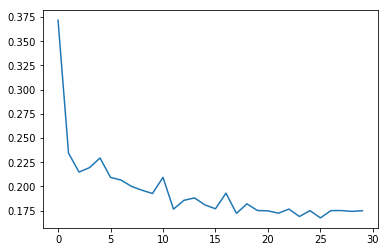

In [7]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

epochs = 30
loss_list = []
for epoch in range(epochs):
    total_loss = []
    target_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target_list.append(target.item())
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(loss_list[-1])

# Normalise the loss between 0 and 1
for i in range(len(loss_list)):
    loss_list[i] += 1

# Plot the loss per epoch
plt.plot(loss_list)

### What now?
While it is totally possible to create hybrid neural networks, does this actually have any benefit? In fact, the classical layers of this network train perfectly fine (if not better) without the quantum node. The point of this exercise is to get you to start thinking about integrating techniques from ML and quantum computing in order to investigate if there is indeed some element of interest - and thanks to PyTorch and Qiskit, this becomes a little bit easier. 

*Notebook author: Amira Abbas (amyami187@gmail.com)*.
*Code contributors: Karel Dumon, Patrick Huembeli, Amira Abbas, Isaac Turtletaub, Christa Zoufal.*